In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path
from scipy.stats import pearsonr

In [2]:
CLASSIFIERS = ['CART', 'KNN', 'SVM', 'MLP']
CRITERIA = ['AUC', 'BAC', 'G-mean', 'F-beta']

FIGURES_PATH = Path('figures')
FIGURES_PATH.mkdir(exist_ok=True, parents=True)

In [3]:
df = pd.read_csv('stats.csv')

In [4]:
df

,Dataset,Fold,Classifier,Criterion,Minority,Majority,Oversampling,Undersampling
0,ecoli-0-1_vs_2-3-5,1,CART,G-mean,"{0: 3, 1: 1, 2: 2, 3: None, 4: 6}","{0: None, 1: None, 2: None, 3: 18, 4: 92}","{0: 15, 1: 12, 2: 29, 3: None, 4: 25}","{0: None, 1: None, 2: None, 3: 14, 4: 44}"
1,page-blocks-1-3_vs_4,9,MLP,F-beta,"{0: 2, 1: 1, 2: 1, 3: 6, 4: 4}","{0: None, 1: 3, 2: 1, 3: 2, 4: 216}","{0: 47, 1: 238, 2: 211, 3: 187, 4: 223}","{0: None, 1: 2, 2: 1, 3: 0, 4: 4}"
2,abalone-19_vs_10-11-12-13,4,CART,AUC,"{0: 12, 1: 4, 2: None, 3: None, 4: None}","{0: None, 1: None, 2: 3, 3: 44, 4: 748}","{0: 530, 1: 1573, 2: None, 3: None, 4: None}","{0: None, 1: None, 2: 0, 3: 33, 4: 36}"
3,ecoli-0-6-7_vs_3-5,2,SVM,AUC,"{0: 1, 1: 2, 2: 2, 3: 4, 4: 2}","{0: None, 1: 1, 2: 2, 3: 5, 4: 92}","{0: 5, 1: 4, 2: 1, 3: 5, 4: 4}","{0: None, 1: 1, 2: 0, 3: 3, 4: 47}"
4,glass4,9,MLP,G-mean,"{0: 2, 1: 3, 2: 1, 3: None, 4: None}","{0: None, 1: None, 2: 1, 3: 5, 4: 95}","{0: 72, 1: 190, 2: 97, 3: None, 4: None}","{0: None, 1: None, 2: 0, 3: 2, 4: 17}"
...,...,...,...,...,...,...,...,...
9595,poker-8-9_vs_6,8,KNN,G-mean,"{0: 4, 1: 5, 2: None, 3: 3, 4: None}","{0: None, 1: None, 2: None, 3: 15, 4: 715}","{0: 2698, 1: 49, 2: None, 3: 695, 4: None}","{0: None, 1: None, 2: None, 3: 1, 4: 4}"
9596,ecoli2,2,SVM,F-beta,"{0: 2, 1: 1, 2: 3, 3: 7, 4: 13}","{0: 3, 1: 1, 2: 4, 3: 15, 4: 119}","{0: 93, 1: 124, 2: 69, 3: 114, 4: 149}","{0: 0, 1: 0, 2: 2, 3: 12, 4: 100}"
9597,glass4,6,CART,G-mean,"{0: 2, 1: 1, 2: 1, 3: 3, 4: None}","{0: None, 1: 1, 2: 2, 3: 4, 4: 93}","{0: 27, 1: 28, 2: 15, 3: 8, 4: None}","{0: None, 1: 1, 2: 2, 3: 2, 4: 32}"
9598,cleveland-0_vs_4,3,CART,F-beta,"{0: None, 1: 1, 2: 5, 3: None, 4: 1}","{0: None, 1: None, 2: 2, 3: 2, 4: 76}","{0: None, 1: 55, 2: 10, 3: None, 4: 10}","{0: None, 1: None, 2: 0, 3: 2, 4: 75}"


In [5]:
for c in ['Minority', 'Majority', 'Oversampling', 'Undersampling']:
    df[c] = df[c].map(lambda x: eval(x))
    df[c] = df[c].map(lambda x: np.array([x[i] if x[i] is not None else np.nan for i in range(5)]))

In [6]:
df['# minority'] = df['Minority'].map(lambda x: np.nansum(x))
df['# majority'] = df['Majority'].map(lambda x: np.nansum(x))
df['# oversampled'] = df['Oversampling'].map(lambda x: np.nansum(x))
df['# undersampled'] = df['Undersampling'].map(lambda x: np.nansum(x))
df['IR (before resampling)'] = df['# majority'] / df['# minority']
df['IR (after resampling)'] = (df['# majority'] - df['# undersampled']) / (df['# minority'] + df['# oversampled'])
df['Oversampling proportion'] = df['# oversampled'] / (df['# minority'] + df['# majority'])
df['Undersampling proportion'] = df['# undersampled'] / (df['# minority'] + df['# majority'])

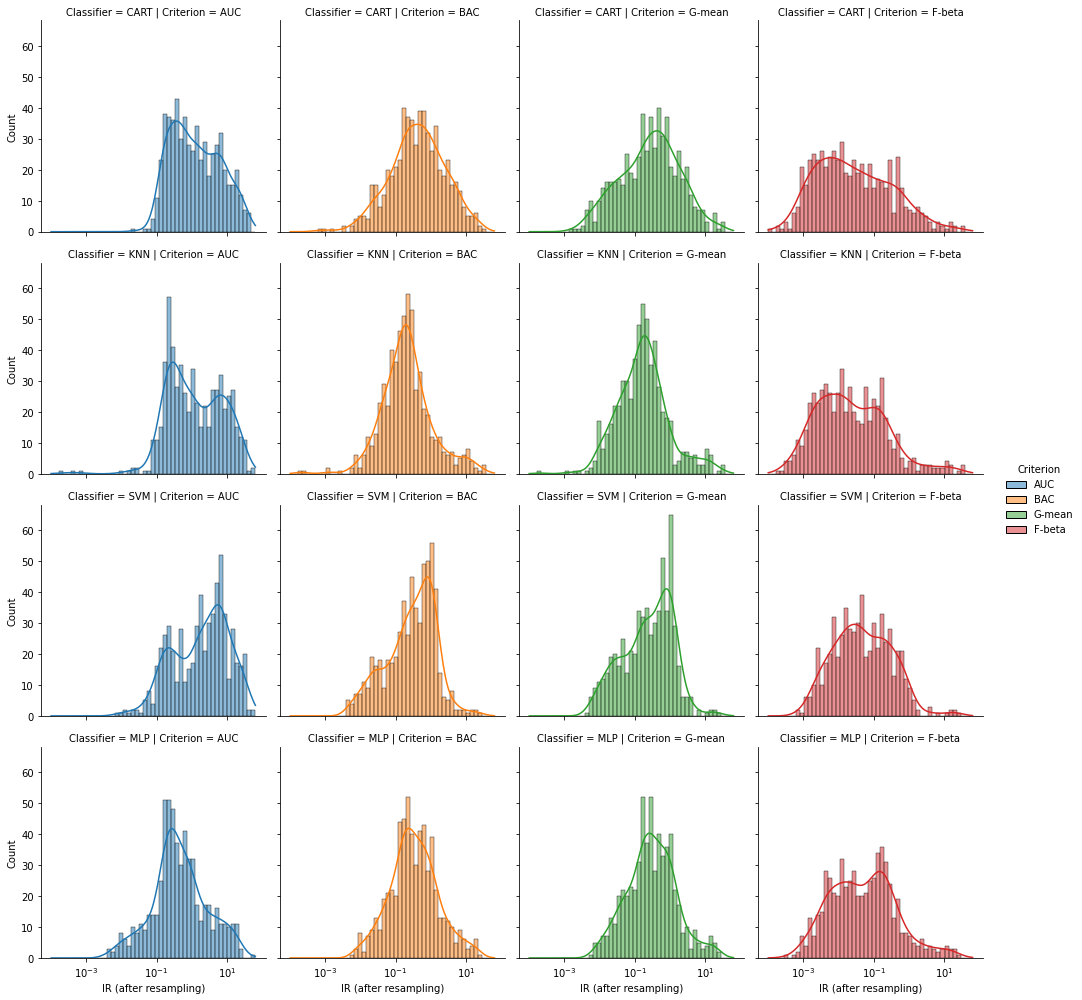

In [7]:
g = sns.displot(
    df, x='IR (after resampling)', row='Classifier', 
    col='Criterion', hue='Criterion', row_order=CLASSIFIERS, 
    col_order=CRITERIA, hue_order=CRITERIA,
    log_scale=True, height=3.5, kde=True
)
plt.savefig(FIGURES_PATH / 'IR_after_dist.pdf')

In [8]:
df['log IR (before resampling)'] = np.log(df['IR (before resampling)'])
df['log IR (after resampling)'] = np.log(df['IR (after resampling)'])
df['# samples'] = df['# minority'] + df['# majority']
df['log # samples'] = np.log(df['# samples'])

(array([ 160., 2080.,  800., 1120., 1280., 1280., 1760.,  800.,    0.,
         320.]),
 array([3.91202301, 4.31224593, 4.71246886, 5.11269179, 5.51291471,
        5.91313764, 6.31336057, 6.7135835 , 7.11380642, 7.51402935,
        7.91425228]),
 <BarContainer object of 10 artists>)

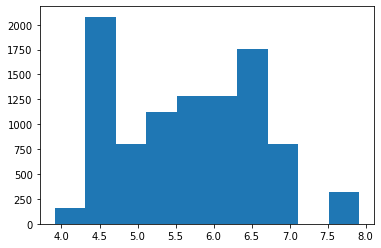

In [9]:
plt.hist(df['log # samples'])

In [10]:
df['log # samples bins'] = pd.cut(df['log # samples'], bins=[3, 4, 5, 6, 7, 8])

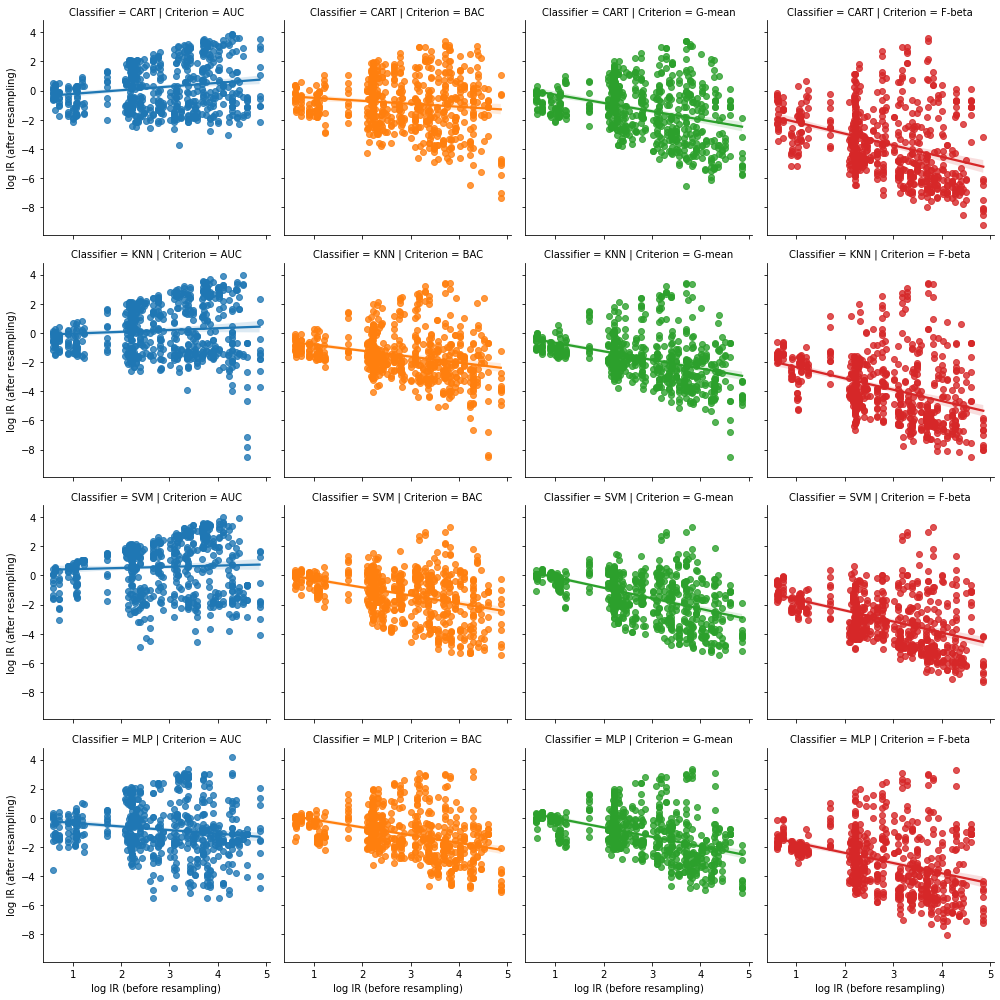

In [11]:
g = sns.lmplot(
    data=df, x='log IR (before resampling)', y='log IR (after resampling)', 
    row='Classifier', col='Criterion', hue='Criterion', 
    row_order=CLASSIFIERS, col_order=CRITERIA, hue_order=CRITERIA,
    height=3.5
)
plt.savefig(FIGURES_PATH / 'IR_before_vs_IR_after.pdf')

In [12]:
rows = []
rows.append([''] + CRITERIA)

for classifier in CLASSIFIERS:
    row = [classifier]
    
    for criterion in CRITERIA:
        x = df[(df['Classifier'] == classifier) & (df['Criterion'] == criterion)]['log IR (before resampling)']
        y = df[(df['Classifier'] == classifier) & (df['Criterion'] == criterion)]['log IR (after resampling)']
        
        rho, pval = pearsonr(x, y)
        
        row.append(f'{rho:.2f} (p = {pval:.4f})')
    
    rows.append(row)

pd.DataFrame(rows)

,0,1,2,3,4
0,,AUC,BAC,G-mean,F-beta
1,CART,0.17 (p = 0.0000),-0.12 (p = 0.0026),-0.32 (p = 0.0000),-0.35 (p = 0.0000)
2,KNN,0.07 (p = 0.0729),-0.27 (p = 0.0000),-0.38 (p = 0.0000),-0.37 (p = 0.0000)
3,SVM,0.05 (p = 0.2372),-0.37 (p = 0.0000),-0.47 (p = 0.0000),-0.43 (p = 0.0000)
4,MLP,-0.15 (p = 0.0003),-0.37 (p = 0.0000),-0.43 (p = 0.0000),-0.35 (p = 0.0000)


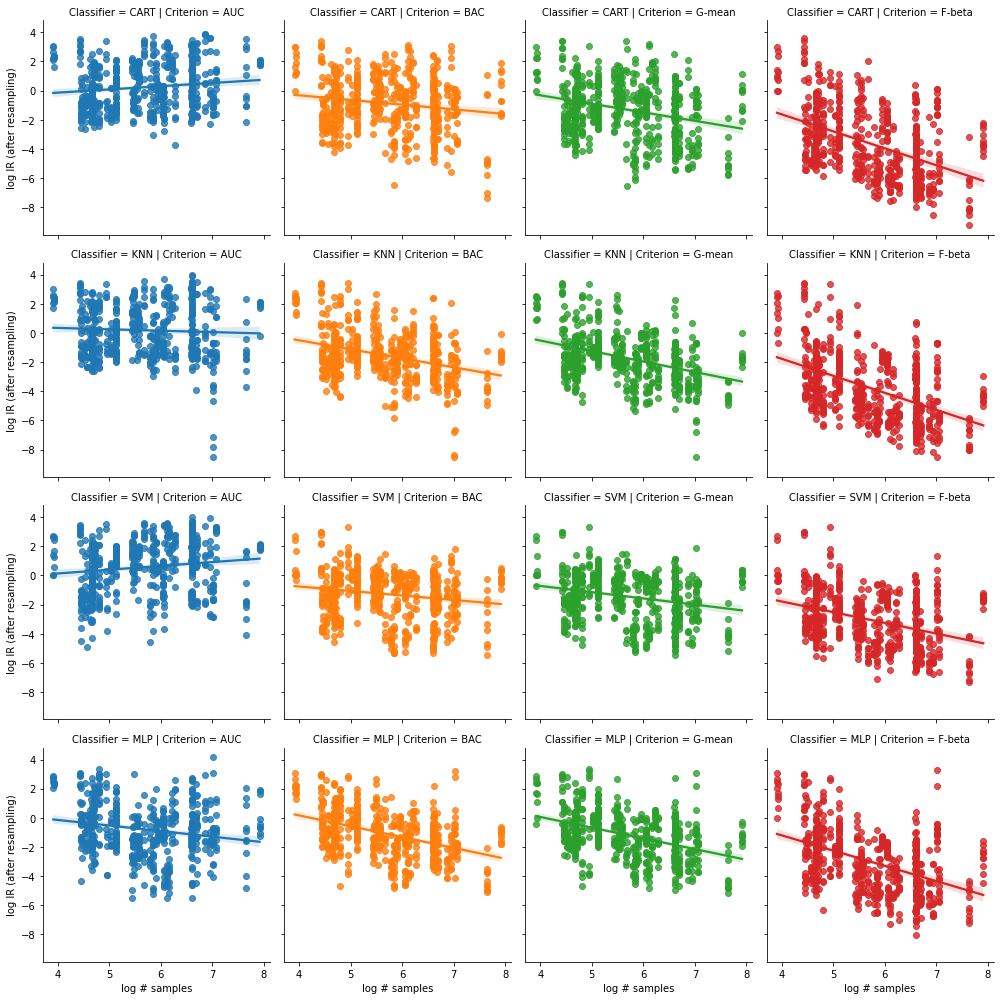

In [13]:
g = sns.lmplot(
    data=df, x='log # samples', y='log IR (after resampling)', 
    row='Classifier', col='Criterion', hue='Criterion', 
    row_order=CLASSIFIERS, col_order=CRITERIA, hue_order=CRITERIA,
    height=3.5
)
plt.savefig(FIGURES_PATH / 'n_samples_vs_IR_after.pdf')

In [14]:
rows = []
rows.append([''] + CRITERIA)

for classifier in CLASSIFIERS:
    row = [classifier]
    
    for criterion in CRITERIA:
        x = df[(df['Classifier'] == classifier) & (df['Criterion'] == criterion)]['log # samples']
        y = df[(df['Classifier'] == classifier) & (df['Criterion'] == criterion)]['log IR (after resampling)']
        
        rho, pval = pearsonr(x, y)
        
        row.append(f'{rho:.2f} (p = {pval:.4f})')
    
    rows.append(row)

pd.DataFrame(rows)

,0,1,2,3,4
0,,AUC,BAC,G-mean,F-beta
1,CART,0.13 (p = 0.0017),-0.17 (p = 0.0000),-0.28 (p = 0.0000),-0.44 (p = 0.0000)
2,KNN,-0.05 (p = 0.2310),-0.35 (p = 0.0000),-0.40 (p = 0.0000),-0.48 (p = 0.0000)
3,SVM,0.13 (p = 0.0010),-0.18 (p = 0.0000),-0.24 (p = 0.0000),-0.36 (p = 0.0000)
4,MLP,-0.20 (p = 0.0000),-0.44 (p = 0.0000),-0.43 (p = 0.0000),-0.46 (p = 0.0000)


In [15]:
df['IR (after resampling)']

0       0.559140
1       0.233696
2       0.342614
3       1.633333
4       0.224658
          ...   
9595    0.209902
9596    0.048696
9597    0.741176
9598    0.036585
9599    0.004046
Name: IR (after resampling), Length: 9600, dtype: float64

In [16]:
df['IR (before resampling)'].mean().round(2)

28.12

In [17]:
df['IR (after resampling)'].mean().round(2)

1.72

In [18]:
rows = []
rows.append([''] + CRITERIA)

for classifier in CLASSIFIERS:
    row = [classifier]
    
    for criterion in CRITERIA:
        ir = df[(df['Classifier'] == classifier) & (df['Criterion'] == criterion)]['IR (after resampling)']
        
        row.append(f'{np.mean(ir):.2f} ± {np.std(ir):.2f}')
    
    rows.append(row)

pd.DataFrame(rows)

,0,1,2,3,4
0,,AUC,BAC,G-mean,F-beta
1,CART,4.29 ± 7.43,1.64 ± 3.44,1.31 ± 3.38,0.54 ± 2.60
2,KNN,4.52 ± 7.39,1.06 ± 3.30,0.95 ± 3.14,0.55 ± 2.81
3,SVM,5.79 ± 8.40,0.82 ± 2.06,0.74 ± 1.99,0.37 ± 1.93
4,MLP,2.04 ± 4.76,1.19 ± 2.88,1.17 ± 3.09,0.60 ± 2.43


In [19]:
df['# oversampled'].mean()

861.7623958333334

In [20]:
df['# undersampled'].mean()

260.81822916666664

In [21]:
df['Adjusted O/U ratio'] = (df['# oversampled'] + 1) / (df['# undersampled'] + 1)
df['log Adjusted O/U ratio'] = np.log(df['Adjusted O/U ratio'])

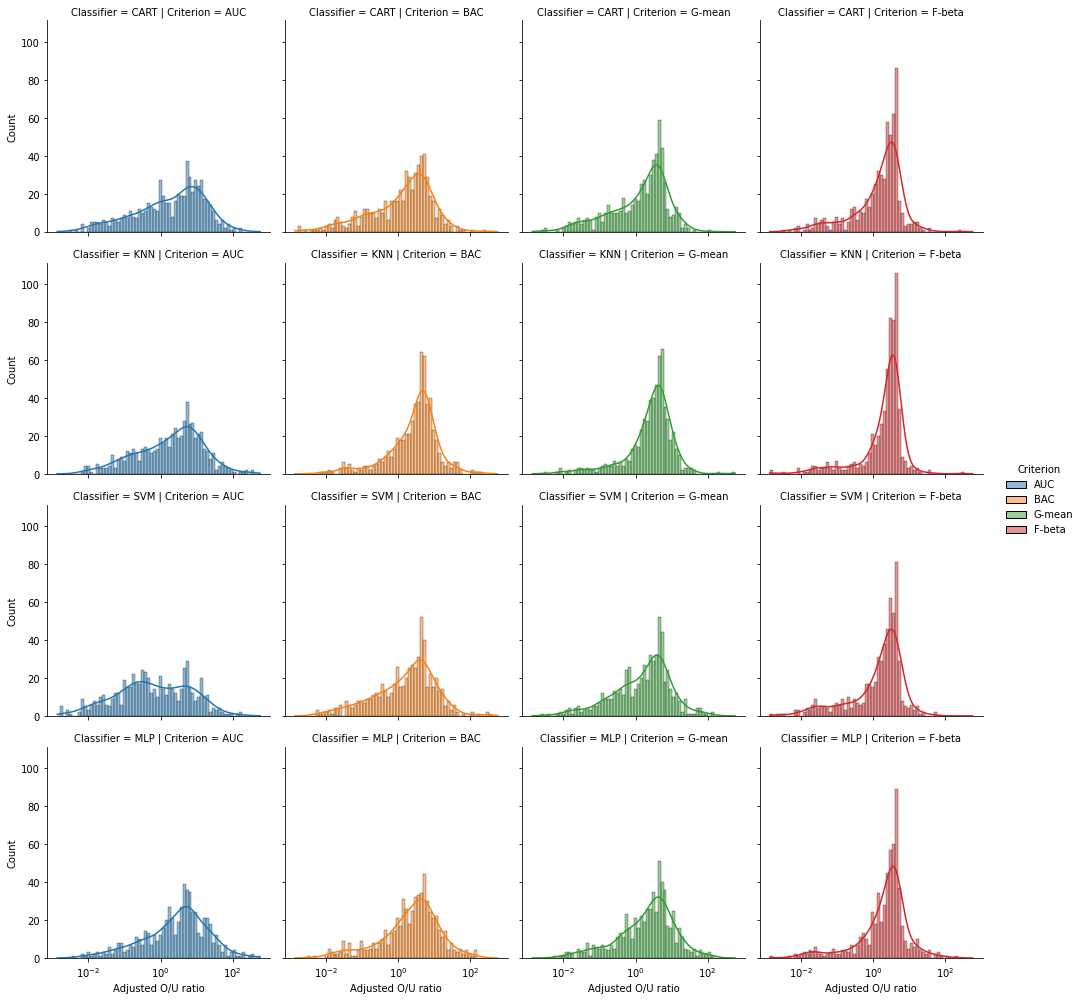

In [22]:
g = sns.displot(
    df, x='Adjusted O/U ratio', row='Classifier', 
    col='Criterion', hue='Criterion', row_order=CLASSIFIERS, 
    col_order=CRITERIA, hue_order=CRITERIA,
    log_scale=True, height=3.5, kde=True
)
plt.savefig(FIGURES_PATH / 'OU_ratio_dist.pdf')

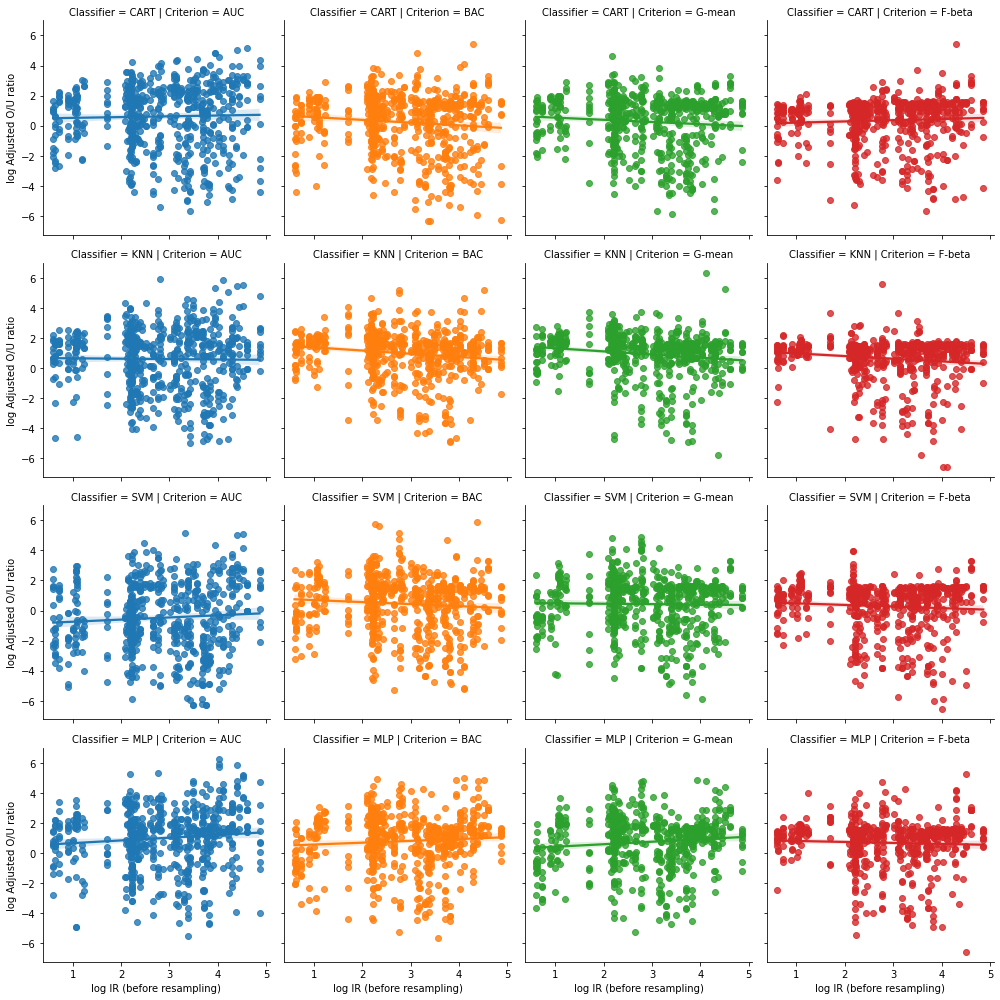

In [23]:
g = sns.lmplot(
    data=df, x='log IR (before resampling)', y='log Adjusted O/U ratio', 
    row='Classifier', col='Criterion', hue='Criterion', 
    row_order=CLASSIFIERS, col_order=CRITERIA, hue_order=CRITERIA,
    height=3.5
)
plt.savefig(FIGURES_PATH / 'IR_before_vs_OU_ratio.pdf')

In [24]:
rows = []
rows.append([''] + CRITERIA)

for classifier in CLASSIFIERS:
    row = [classifier]
    
    for criterion in CRITERIA:
        x = df[(df['Classifier'] == classifier) & (df['Criterion'] == criterion)]['log IR (before resampling)']
        y = df[(df['Classifier'] == classifier) & (df['Criterion'] == criterion)]['log Adjusted O/U ratio']
        
        rho, pval = pearsonr(x, y)
        
        row.append(f'{rho:.2f} (p = {pval:.4f})')
    
    rows.append(row)

pd.DataFrame(rows)

,0,1,2,3,4
0,,AUC,BAC,G-mean,F-beta
1,CART,0.03 (p = 0.5232),-0.10 (p = 0.0140),-0.09 (p = 0.0366),0.06 (p = 0.1728)
2,KNN,-0.01 (p = 0.7437),-0.15 (p = 0.0003),-0.15 (p = 0.0002),-0.13 (p = 0.0011)
3,SVM,0.07 (p = 0.1055),-0.07 (p = 0.0666),-0.02 (p = 0.6874),-0.07 (p = 0.1010)
4,MLP,0.10 (p = 0.0181),0.07 (p = 0.0824),0.10 (p = 0.0136),-0.04 (p = 0.2885)


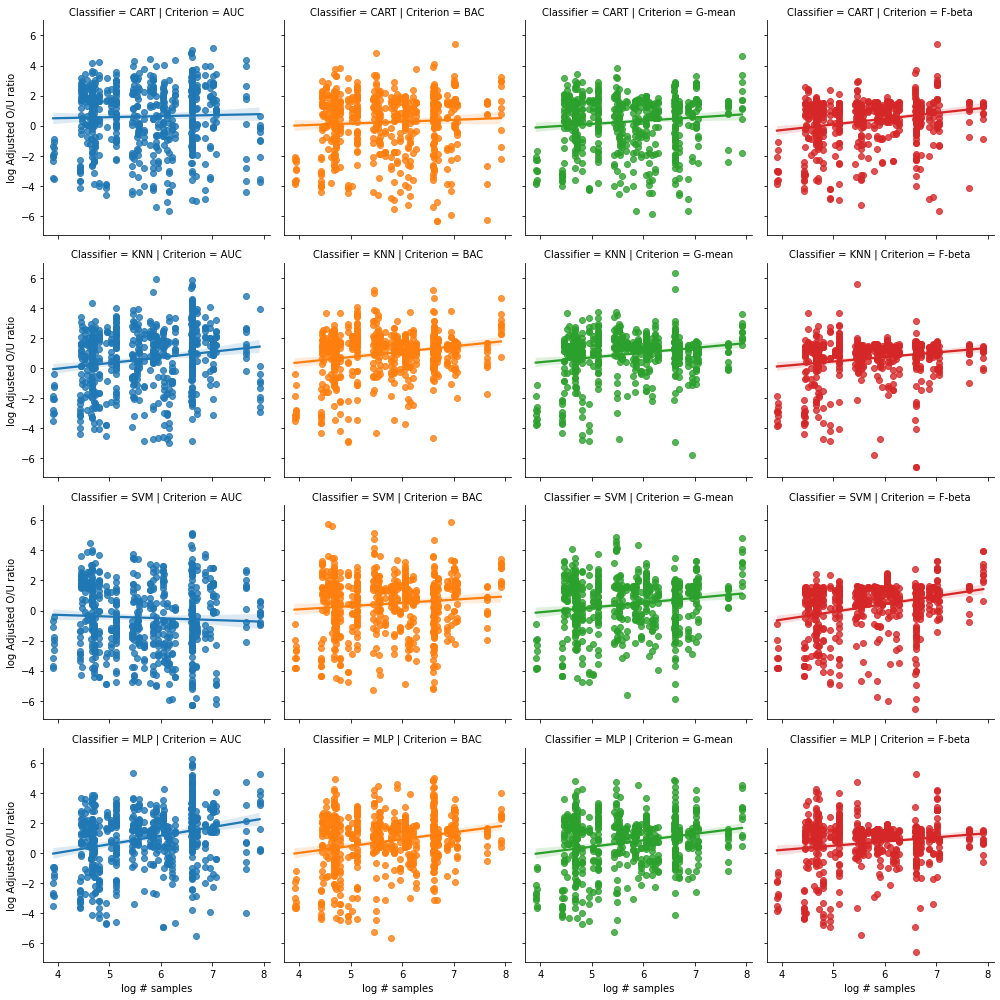

In [25]:
g = sns.lmplot(
    data=df, x='log # samples', y='log Adjusted O/U ratio', 
    row='Classifier', col='Criterion', hue='Criterion', 
    row_order=CLASSIFIERS, col_order=CRITERIA, hue_order=CRITERIA,
    height=3.5
)
plt.savefig(FIGURES_PATH / 'n_samples_vs_OU_ratio.pdf')

In [26]:
rows = []
rows.append([''] + CRITERIA)

for classifier in CLASSIFIERS:
    row = [classifier]
    
    for criterion in CRITERIA:
        x = df[(df['Classifier'] == classifier) & (df['Criterion'] == criterion)]['log # samples']
        y = df[(df['Classifier'] == classifier) & (df['Criterion'] == criterion)]['log Adjusted O/U ratio']
        
        rho, pval = pearsonr(x, y)
        
        row.append(f'{rho:.2f} (p = {pval:.4f})')
    
    rows.append(row)

pd.DataFrame(rows)

,0,1,2,3,4
0,,AUC,BAC,G-mean,F-beta
1,CART,0.03 (p = 0.4704),0.06 (p = 0.1513),0.11 (p = 0.0066),0.22 (p = 0.0000)
2,KNN,0.17 (p = 0.0000),0.21 (p = 0.0000),0.20 (p = 0.0000),0.19 (p = 0.0000)
3,SVM,-0.05 (p = 0.2639),0.10 (p = 0.0109),0.16 (p = 0.0001),0.28 (p = 0.0000)
4,MLP,0.26 (p = 0.0000),0.23 (p = 0.0000),0.22 (p = 0.0000),0.16 (p = 0.0001)


In [27]:
rows = []
rows.append([''] + CRITERIA)

for classifier in CLASSIFIERS:
    row = [classifier]
    
    for criterion in CRITERIA:
        ou = df[(df['Classifier'] == classifier) & (df['Criterion'] == criterion)]['Adjusted O/U ratio']
        
        row.append(f'{np.mean(ou):.2f} ± {np.std(ou):.2f}')
    
    rows.append(row)

pd.DataFrame(rows)

,0,1,2,3,4
0,,AUC,BAC,G-mean,F-beta
1,CART,8.33 ± 16.52,4.54 ± 12.07,3.70 ± 6.29,3.26 ± 9.79
2,KNN,9.57 ± 29.41,6.66 ± 14.95,6.01 ± 24.93,3.65 ± 11.32
3,SVM,4.83 ± 14.44,6.81 ± 25.06,5.29 ± 12.14,2.97 ± 4.11
4,MLP,12.99 ± 38.20,7.58 ± 16.17,6.77 ± 14.34,4.88 ± 11.54


In [28]:
df

,Dataset,Fold,Classifier,Criterion,Minority,Majority,Oversampling,Undersampling,# minority,# majority,...,IR (after resampling),Oversampling proportion,Undersampling proportion,log IR (before resampling),log IR (after resampling),# samples,log # samples,log # samples bins,Adjusted O/U ratio,log Adjusted O/U ratio
0,ecoli-0-1_vs_2-3-5,1,CART,G-mean,"[3.0, 1.0, 2.0, nan, 6.0]","[nan, nan, nan, 18.0, 92.0]","[15.0, 12.0, 29.0, nan, 25.0]","[nan, nan, nan, 14.0, 44.0]",12.0,110.0,...,0.559140,0.663934,0.475410,2.215574,-0.581356,122.0,4.804021,"(4, 5]",1.389831,0.329182
1,page-blocks-1-3_vs_4,9,MLP,F-beta,"[2, 1, 1, 6, 4]","[nan, 3.0, 1.0, 2.0, 216.0]","[47, 238, 211, 187, 223]","[nan, 2.0, 1.0, 0.0, 4.0]",14.0,222.0,...,0.233696,3.838983,0.029661,2.763620,-1.453736,236.0,5.463832,"(5, 6]",113.375000,4.730701
2,abalone-19_vs_10-11-12-13,4,CART,AUC,"[12.0, 4.0, nan, nan, nan]","[nan, nan, 3.0, 44.0, 748.0]","[530.0, 1573.0, nan, nan, nan]","[nan, nan, 0.0, 33.0, 36.0]",16.0,795.0,...,0.342614,2.593095,0.085080,3.905753,-1.071150,811.0,6.698268,"(6, 7]",30.057143,3.403100
3,ecoli-0-6-7_vs_3-5,2,SVM,AUC,"[1, 2, 2, 4, 2]","[nan, 1.0, 2.0, 5.0, 92.0]","[5, 4, 1, 5, 4]","[nan, 1.0, 0.0, 3.0, 47.0]",11.0,100.0,...,1.633333,0.171171,0.459459,2.207275,0.490623,111.0,4.709530,"(4, 5]",0.384615,-0.955511
4,glass4,9,MLP,G-mean,"[2.0, 3.0, 1.0, nan, nan]","[nan, nan, 1.0, 5.0, 95.0]","[72.0, 190.0, 97.0, nan, nan]","[nan, nan, 0.0, 2.0, 17.0]",6.0,101.0,...,0.224658,3.355140,0.177570,2.823361,-1.493178,107.0,4.672829,"(4, 5]",18.000000,2.890372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,poker-8-9_vs_6,8,KNN,G-mean,"[4.0, 5.0, nan, 3.0, nan]","[nan, nan, nan, 15.0, 715.0]","[2698.0, 49.0, nan, 695.0, nan]","[nan, nan, nan, 1.0, 4.0]",12.0,730.0,...,0.209902,4.638814,0.006739,4.108138,-1.561117,742.0,6.609349,"(6, 7]",573.833333,6.352339
9596,ecoli2,2,SVM,F-beta,"[2, 1, 3, 7, 13]","[3, 1, 4, 15, 119]","[93, 124, 69, 114, 149]","[0, 0, 2, 12, 100]",26.0,142.0,...,0.048696,3.267857,0.678571,1.697731,-3.022166,168.0,5.123964,"(5, 6]",4.782609,1.564986
9597,glass4,6,CART,G-mean,"[2.0, 1.0, 1.0, 3.0, nan]","[nan, 1.0, 2.0, 4.0, 93.0]","[27.0, 28.0, 15.0, 8.0, nan]","[nan, 1.0, 2.0, 2.0, 32.0]",7.0,100.0,...,0.741176,0.728972,0.345794,2.659260,-0.299517,107.0,4.672829,"(4, 5]",2.078947,0.731862
9598,cleveland-0_vs_4,3,CART,F-beta,"[nan, 1.0, 5.0, nan, 1.0]","[nan, nan, 2.0, 2.0, 76.0]","[nan, 55.0, 10.0, nan, 10.0]","[nan, nan, 0.0, 2.0, 75.0]",7.0,80.0,...,0.036585,0.862069,0.885057,2.436116,-3.308107,87.0,4.465908,"(4, 5]",0.974359,-0.025975


In [29]:
rows = []
rows.append([''] + [f'k = {k}' for k in range(5)])

for kind in ['Minority', 'Majority']:
    row = [kind]

    for k in range(5):
        pr = df[kind].map(lambda x: np.nan_to_num(x[k] / np.nansum(x)))
        
        row.append(f'{np.mean(pr):.3f} ± {np.std(pr):.3f}')
    
    rows.append(row)
            
pd.DataFrame(rows)

,0,1,2,3,4,5
0,,k = 0,k = 1,k = 2,k = 3,k = 4
1,Minority,0.370 ± 0.289,0.234 ± 0.190,0.156 ± 0.163,0.122 ± 0.144,0.118 ± 0.185
2,Majority,0.003 ± 0.008,0.011 ± 0.025,0.028 ± 0.047,0.090 ± 0.085,0.868 ± 0.148


In [30]:
rows = []
rows.append([''] + [f'k = {k}' for k in range(5)])

for kind in ['Minority', 'Majority']:
    row = [kind]

    for k in range(5):
        pe = df[kind].map(lambda x: np.nan_to_num(x[k]) > 0).sum() / len(df) * 100
        
        row.append(f'{np.mean(pe):.1f}%')
    
    rows.append(row)
            
pd.DataFrame(rows)

,0,1,2,3,4,5
0,,k = 0,k = 1,k = 2,k = 3,k = 4
1,Minority,94.7%,86.3%,69.8%,53.5%,43.3%
2,Majority,25.2%,41.5%,74.8%,95.7%,100.0%


In [31]:
df['Oversampling (normalized by # minority)'] = df['Oversampling'] / df['# minority']
df['Undersampling (normalized by # majority)'] = df['Undersampling'] / df['# majority']

In [32]:
np.nanmean(np.array([x for x in df['Oversampling (normalized by # minority)'].values]), axis=0)

array([25.35004013, 18.75872429, 11.69343588,  8.90574291,  8.98682289])

In [33]:
np.nanmean(np.array([x for x in df['Undersampling (normalized by # majority)'].values]), axis=0)

array([0.00858195, 0.01871908, 0.02647337, 0.06115678, 0.48124681])

In [34]:
df['Oversampling (normalized by # individual types)'] = df['Oversampling'] / df['Minority']
df['Undersampling (normalized by # individual types)'] = df['Undersampling'] / df['Majority']

In [35]:
np.nanmean(np.array([x for x in df['Oversampling (normalized by # individual types)'].values]), axis=0)

array([ 66.55705083, 109.38948303,  88.20038513,  54.08804946,
        44.74712492])

In [36]:
np.nanmean(np.array([x for x in df['Undersampling (normalized by # individual types)'].values]), axis=0)

array([0.70910167, 0.66957862, 0.67906404, 0.68559624, 0.53341028])

In [37]:
rows = []
cases = [
    'Oversampling (normalized by # minority)', 
    'Oversampling (normalized by # individual types)',
    'Undersampling (normalized by # majority)', 
    'Undersampling (normalized by # individual types)'
]

for _, row in df.iterrows():
    for col in cases:
        for k in range(5):
            rows.append([col, k, row[col][k]])

dx = pd.DataFrame(rows, columns=['Case', 'K', 'Proportion'])
dx

,Case,K,Proportion
0,Oversampling (normalized by # minority),0,1.250000
1,Oversampling (normalized by # minority),1,1.000000
2,Oversampling (normalized by # minority),2,2.416667
3,Oversampling (normalized by # minority),3,NaN
4,Oversampling (normalized by # minority),4,2.083333
...,...,...,...
191995,Undersampling (normalized by # individual types),0,NaN
191996,Undersampling (normalized by # individual types),1,NaN
191997,Undersampling (normalized by # individual types),2,0.000000
191998,Undersampling (normalized by # individual types),3,0.300000


In [38]:
rows = []
rows.append([''] + [f'k = {k}' for k in range(5)])

for case in cases:
    row = [case]

    for k in range(5):
        pr = dx[(dx['Case'] == case) & (dx['K'] == k)]['Proportion']
        
        row.append(f'{np.mean(pr):.3f} ± {np.std(pr):.3f}')
    
    rows.append(row)
            
pd.DataFrame(rows)

,0,1,2,3,4,5
0,,k = 0,k = 1,k = 2,k = 3,k = 4
1,Oversampling (normalized by # minority),25.350 ± 56.480,18.759 ± 43.719,11.693 ± 25.790,8.906 ± 19.824,8.987 ± 23.320
2,Oversampling (normalized by # individual types),66.557 ± 163.778,109.389 ± 376.313,88.200 ± 258.460,54.088 ± 129.925,44.747 ± 124.061
3,Undersampling (normalized by # majority),0.009 ± 0.010,0.019 ± 0.027,0.026 ± 0.042,0.061 ± 0.064,0.481 ± 0.346
4,Undersampling (normalized by # individual types),0.709 ± 0.375,0.670 ± 0.390,0.679 ± 0.359,0.686 ± 0.339,0.533 ± 0.367
